<a href="https://colab.research.google.com/github/zhenglinchen1096496/DBU-Python/blob/main/Cat_and_Dog_Image_Classification_Model_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.mixed_precision import set_global_policy
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
# 启用混合精度
set_global_policy('mixed_float16')

# 加载数据集
dataset, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.FYD45G_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [13]:
# 查看前 5 张图像的原始像素大小
for i, (image, label) in enumerate(dataset['train'].take(5)):
    print(f"图像 {i+1} 像素大小: {image.shape}, 标签: {'狗' if label.numpy() == 1 else '猫'}")

图像 1 像素大小: (262, 350, 3), 标签: 狗
图像 2 像素大小: (409, 336, 3), 标签: 狗
图像 3 像素大小: (493, 500, 3), 标签: 狗
图像 4 像素大小: (375, 500, 3), 标签: 猫
图像 5 像素大小: (240, 320, 3), 标签: 狗


In [14]:

total_samples = info.splits['train'].num_examples  # 23262

# 70%/30% 分割
train_full_samples = int(total_samples * 0.7)  # 18610
test_full_samples = total_samples - train_full_samples  # 4652

# 除以 3
train_samples = train_full_samples // 3  # 18610 ÷ 3 = 6203
test_samples = test_full_samples // 3    # 4652 ÷ 3 = 1550
test_samples += 1  # 调整为 1551，保持比例

# 随机打乱索引
indices = np.arange(total_samples)
np.random.shuffle(indices)

# 70%/30% 索引
train_full_indices = indices[:train_full_samples]
test_full_indices = indices[train_full_samples:train_full_samples + test_full_samples]

# 从训练和测试集中各抽取 1/3
np.random.shuffle(train_full_indices)  # 再次打乱训练索引
np.random.shuffle(test_full_indices)   # 再次打乱测试索引
train_indices = train_full_indices[:train_samples]  # 6203
test_indices = test_full_indices[:test_samples]    # 1551

# 创建训练和测试数据集
train_dataset = dataset['train'].enumerate().filter(
    lambda i, x: tf.reduce_any(tf.equal(i, train_indices))
).map(lambda i, x: x)

test_dataset = dataset['train'].enumerate().filter(
    lambda i, x: tf.reduce_any(tf.equal(i, test_indices))
).map(lambda i, x: x)


# 提取 y_train 和 y_test
y_train = [int(label.numpy()) for _, label in train_dataset]
y_test = [int(label.numpy()) for _, label in test_dataset]



In [ ]:
# # 取一张图片
# for image, label in dataset['train'].take(1):
#     print("Original image shape:", image.shape)
#     print("Original data type:", image.dtype)
#     print("Original pixel range: min =", tf.reduce_min(image).numpy(),
#           "max =", tf.reduce_max(image).numpy())

#     # 调整大小
#     resized_image = tf.image.resize(image, [96, 96])

#     # 检查调整后的信息
#     print("\nResized image shape:", resized_image.shape)
#     print("Resized data type:", resized_image.dtype)
#     print("Resized pixel range: min =", tf.reduce_min(resized_image).numpy(),
#           "max =", tf.reduce_max(resized_image).numpy())

In [15]:
# 预处理
def preprocess(image, label):
    image = tf.image.resize(image, [96, 96])
    # image = image / 255.0
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label


# 数据管道
BATCH_SIZE = 128
# 训练数据集（批处理）
train_dataset = train_dataset.map(preprocess).shuffle(1000).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
# 测试数据集（批处理，用于评估）
test_dataset_batched = test_dataset.map(preprocess).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
# 测试数据集（非批处理，用于单张图片预测）
test_dataset_single = test_dataset.map(preprocess)


In [17]:
# 打印信息（分两段）
print(f"训练样本数量: {len(y_train)}")
print(f"测试样本数量: {len(y_test)}")
print(f"y_train 前10个标签: {y_train[:10]}")
print(f"y_test 前10个标签: {y_test[:10]}")
print(f"标签类别: {info.features['label'].names} (0=cat, 1=dog)")
print("\n")
print("y_train 标签分布:")
print(f"猫 (label 0): {y_train.count(0)} ({y_train.count(0)/len(y_train)*100:.2f}%)")
print(f"狗 (label 1): {y_train.count(1)} ({y_train.count(1)/len(y_train)*100:.2f}%)")
print("\ny_test 标签分布:")
print(f"猫 (label 0): {y_test.count(0)} ({y_test.count(0)/len(y_test)*100:.2f}%)")
print(f"狗 (label 1): {y_test.count(1)} ({y_test.count(1)/len(y_test)*100:.2f}%)")

训练样本数量: 5427
测试样本数量: 2327
y_train 前10个标签: [0, 0, 1, 0, 0, 1, 0, 0, 0, 0]
y_test 前10个标签: [1, 0, 0, 1, 0, 1, 0, 1, 1, 1]
标签类别: ['cat', 'dog'] (0=cat, 1=dog)


y_train 标签分布:
猫 (label 0): 2758 (50.82%)
狗 (label 1): 2669 (49.18%)

y_test 标签分布:
猫 (label 0): 1173 (50.41%)
狗 (label 1): 1154 (49.59%)


In [18]:
# 打印数据信息
print("TRAINING DATA")
# 训练集样本数量
print(f"Number of images: {train_samples}")
# 检查单张图片的原始形状（从原始 dataset['train'] 获取）
for image, _ in dataset['train'].take(1):
    print(f"Shape of a single image (original): {image.shape}")
# 检查预处理后的形状（从 train_dataset 获取）
for image, _ in train_dataset.take(1):
    print(f"Shape of a single image (preprocessed): {image.shape}")
# 标签数量
print(f"Number of labels: {len(y_train)}")


print("\nTESTING DATA")
# 测试集样本数量
print(f"Number of images: {test_samples}")
# 检查单张图片的原始形状
for image, _ in test_dataset.take(1):
    print(f"Shape of a single image (original): {image.shape}")
# 检查预处理后的形状
for image, _ in test_dataset.map(preprocess).take(1):
    print(f"Shape of a single image (preprocessed): {image.shape}")
# 标签数量
print(f"Number of labels: {len(y_test)}")

# 计算比例
print(f"\nTesting to Training ratio = {test_samples / train_samples:.4f}")

TRAINING DATA
Number of images: 5427
Shape of a single image (original): (262, 350, 3)
Shape of a single image (preprocessed): (128, 96, 96, 3)
Number of labels: 5427

TESTING DATA
Number of images: 2327
Shape of a single image (original): (500, 375, 3)
Shape of a single image (preprocessed): (96, 96, 3)
Number of labels: 2327

Testing to Training ratio = 0.4288


In [19]:
# 数据增强
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

In [20]:
# 模型
base_model = MobileNetV2(input_shape=(96, 96, 3), include_top=False, weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    # data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # 减小学习率
# model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# 早停
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [21]:
# 训练
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset_batched,
    callbacks=[early_stopping]
)

# 评估
test_loss, test_accuracy = model.evaluate(test_dataset_batched)
print(f"测试集准确率: {test_accuracy:.4f}")

Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 56s 919ms/step - accuracy: 0.8026 - loss: 1.5473 - val_accuracy: 0.9583 - val_loss: 0.9112
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9426 - loss: 0.8752 - val_accuracy: 0.9635 - val_loss: 0.6159
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 73s 855ms/step - accuracy: 0.9468 - loss: 0.6094 - val_accuracy: 0.9653 - val_loss: 0.4334
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 42s 914ms/step - accuracy: 0.9516 - loss: 0.4358 - val_accuracy: 0.9666 - val_loss: 0.3263
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 907ms/step - accuracy: 0.9530 - loss: 0.3285 - val_accuracy: 0.9661 - val_loss: 0.2563
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 82s 909ms/step - accuracy: 0.9595 - loss: 0.2739 - val_accuracy: 0.9605 - val_loss: 0.2269
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 39s 851ms/step - accuracy: 0.9542 - loss: 0.2412 - val_accuracy: 0.9648 - val_loss: 0.1979
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9631 - loss: 0.2071 - val_accuracy: 

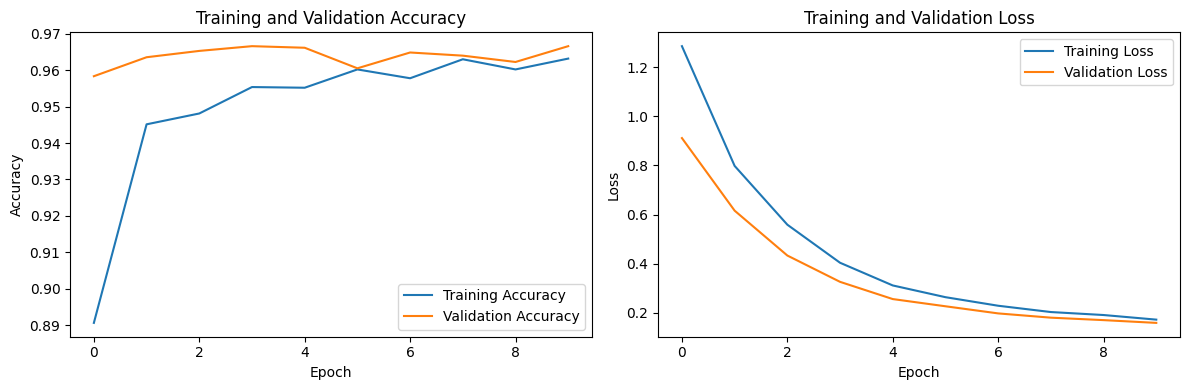

In [22]:
def plot_training_history(history):
    # 获取训练和验证数据
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    # 创建子图
    plt.figure(figsize=(12, 4))

    # 准确率曲线
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # 损失曲线
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 调用绘图函数
plot_training_history(history)


从测试集随机预测 5 张图片：


<ipython-input-23-d312d7f69340>:26: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-23-d312d7f69340>:26: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-23-d312d7f69340>:26: UserWarning: Glyph 29483 (\N{CJK UNIFIED IDEOGRAPH-732B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-23-d312d7f69340>:26: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-23-d312d7f69340>:26: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-23-d312d7f69340>:26: UserWarning: Glyph 29399 (\N{CJK UNIFIED IDEOGRAPH-72D7}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30495 (\N{CJK U

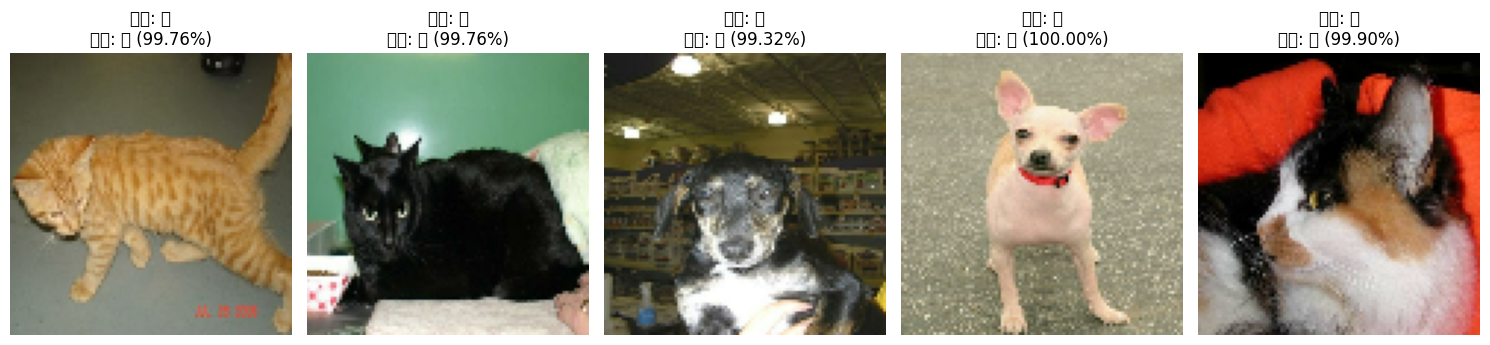

In [23]:

def predict_from_test_dataset(dataset, model, num_images=5):
    # 明确使用 test_dataset_single（非批处理）
    dataset_list = list(dataset.take(num_images))
    random.shuffle(dataset_list)

    plt.figure(figsize=(15, 5))
    for i, (image, label) in enumerate(dataset_list):
        # 确保 image 是单张图片 [96, 96, 3]
        image_np = image.numpy()  # 形状 [96, 96, 3]
        image_batch = np.expand_dims(image_np, axis=0)  # 形状 [1, 96, 96, 3]

        # 预测
        pred = model.predict(image_batch, verbose=0)[0][0]
        pred_label = '狗' if pred > 0.5 else '猫'
        pred_confidence = pred if pred > 0.5 else 1 - pred
        true_label = '狗' if label.numpy() == 1 else '猫'

        # 显示图片
        plt.subplot(1, num_images, i + 1)
        # 将图像从 MobileNetV2 预处理格式转换回显示格式
        image_display = (image_np - image_np.min()) / (image_np.max() - image_np.min())
        plt.imshow(image_display)
        plt.title(f'真实: {true_label}\n预测: {pred_label} ({pred_confidence:.2%})')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

print("\n从测试集随机预测 5 张图片：")
predict_from_test_dataset(test_dataset_single, model, num_images=5)
